## Predict 1 week at a time for dates before 2016
1. Train model for 2 years
2. Predict 1 week via IncrementalModel
3. Repeat starting with next week

In [1]:
from BorderModel import run_Incremental, harmonic_mean
from BorderQuery import insert_predictions
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.grid_search import GridSearchCV
import datetime
import random
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import copy
import pdb
from sklearn.metrics import r2_score
import cPickle as pickle

In [2]:
def create_train_test(date_end, test_days=7, train_years=2):
    '''
    IN 
        date_end: datetime.date of last day to predict
        duration: days to predict
        train_years: number of years to train
    '''
    train_start = date_end - datetime.timedelta(test_days + 366 * train_years)
    train_end = date_end - datetime.timedelta(test_days)
    test_start = date_end - datetime.timedelta(test_days)
    test_end = date_end
    return train_start, train_end, test_start, test_end
    
def run_multiweek(model, munger_id, crossing_id, first, last, test_days):
    prlist = {}
    test_date = first
    while test_date < last:
        cpu = random.randint(0, 31)
        train_start, train_end, test_start, test_end = create_train_test(test_date, test_days=test_days)

        prlist[str(test_date)] = rc[cpu].apply_async(run_Incremental, model, munger_id, crossing_id,  
                                           train_start, train_end, 
                                           test_start, test_end)
        
        test_date += datetime.timedelta(test_days)
        
    return prlist

def score_df(models):
    predict = {date: model.score()['model'] for date, model in models.items()}
    ensemble = {date: model.score()['ensemble'] for date, model in models.items()}
    baseline = {date: model.score()['baseline'] for date, model in models.items()}
    
    df = pd.DataFrame([predict, ensemble, baseline]).T
    df.columns = ['predict', 'ensemble', 'baseline']
    df.index.name = 'date'
    df.index = pd.to_datetime(df.index)
    return df

def plot_scores(df):
    plt.figure(figsize=(16,4))
    plt.plot(df.baseline, label='baseline')
    plt.plot(df.predict, label='predict')
    plt.plot(df.ensemble, label='ensemble')
    plt.axhline(0, color='y')
    plt.legend();
    
def results_df(trained_models):
    predict = pd.Series().append([model.y_predict for key, model in trained_models.items()]).sort_index()
    ensemble = pd.Series().append([model.ensemble() for key, model in trained_models.items()]).sort_index()
    baseline = pd.Series().append([model.baseline() for key, model in trained_models.items()]).sort_index()
    actual = pd.Series().append([model.actual for key, model in trained_models.items()]).sort_index()
  
    df = pd.DataFrame()
    df['predict'] = predict
    df['ensemble'] = ensemble
    df['baseline'] = baseline
    df['actual'] = actual
    return df

def print_r2(results):
    actual = results.actual.dropna()
    print 'Predict: ', r2_score(actual, results.predict[actual.index])
    print 'Ensemble: ', r2_score(actual, results.ensemble[actual.index])
    print 'Baseline: ', r2_score(actual, results.baseline[actual.index])
    
# def get_trained(pr, first, last, test_days, exclude):
def get_trained(pr, exclude):
    trained = {}
    test_date = first
    for date in sorted(pr.keys()):
        if date not in [str(ex) for ex in exclude]:
            if pr[date].ready():
                trained[date] = pr[date].get(1)
                print date, trained[date].score()
            else:
                print date, 'not ready'
            
    return trained

In [3]:
import os
from ipyparallel import Client
rc = Client()
dview = rc[:]

# set proper working directory on all clients
cwd = os.getcwd()
dview.map(os.chdir, [cwd] * 40)
# print(dview.apply_sync(os.getcwd))

with dview.sync_imports():
    import datetime
    from BorderModel import run_Incremental
    from BorderQuery import select_features, select_mungedata_simple, select_mungedata
    from sklearn.ensemble import ExtraTreesRegressor
    from sklearn.grid_search import GridSearchCV

importing datetime on engine(s)
importing run_Incremental from BorderModel on engine(s)
importing select_features,select_mungedata_simple,select_mungedata from BorderQuery on engine(s)
importing ExtraTreesRegressor from sklearn.ensemble on engine(s)
importing GridSearchCV from sklearn.grid_search on engine(s)


## Peace Arch South

### 2015

In [8]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

pr = run_multiweek(grid, 3, 1, datetime.date(2015, 1, 1), datetime.date(2016, 1, 1), 7)

In [16]:
trained = {}
first = datetime.date(2015, 1, 1)
last = datetime.date(2016, 1, 1)
test_days = 7
test_date = first
exclude = [datetime.date(2015, 2, 19)]
while test_date < last:
    if test_date not in exclude:
        if pr[str(test_date)].ready():
            trained[str(test_date)] = pr[str(test_date)].get(1)
            print test_date, trained[str(test_date)].score()
        else:
            print  test_date, pr[str(test_date)].ready()

    test_date += datetime.timedelta(test_days)

2015-01-01 {'model': 0.58128200781843775, 'ensemble': 0.52990815747682307, 'baseline': 0.4953655728098576}
2015-01-08 {'model': 0.12400183899221018, 'ensemble': 0.28527994328097739, 'baseline': 0.3482164076815002}
2015-01-15 {'model': -3.1312980884100128, 'ensemble': -3.4745395708412437, 'baseline': -4.3948089687924909}
2015-01-22 {'model': -0.97769819000414815, 'ensemble': -1.1557025950100703, 'baseline': -1.7942496352676716}
2015-01-29 {'model': -0.46928274087763766, 'ensemble': -0.70397654751423411, 'baseline': -1.5500452984629245}
2015-02-05 {'model': -0.0026863062294202322, 'ensemble': -0.44406904911785161, 'baseline': -2.7982134283227738}
2015-02-12 {'model': 0.66970148363298332, 'ensemble': 0.71106175413340778, 'baseline': 0.52540316434315615}
2015-02-26 {'model': 0.51553721733538704, 'ensemble': 0.56237136261589149, 'baseline': 0.47332788089234268}
2015-03-05 {'model': 0.42326254157553433, 'ensemble': 0.21481358097889702, 'baseline': -0.49784403039616953}
2015-03-12 {'model': 0

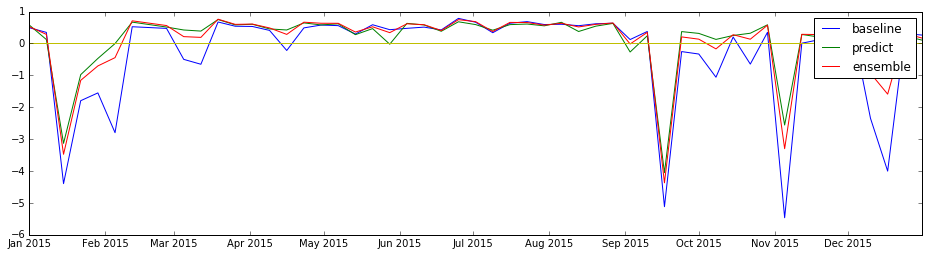

In [18]:
scores = score_df(trained)
plot_scores(scores)

In [24]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_1_2015.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2015-1-1':'2016-1-1'])

Predict:  0.437260053124
Ensemble:  0.453806375313
Baseline:  0.356917688188


### Note that baseline is a rolling 12 months, so not unexpected that baseline improves with week by week approach

In [70]:
full2015 = run_Incremental(grid, 3, 1, '2013-1-1', '2015-1-1', '2015-1-1', '2016-1-1')

In [71]:
full2015.score()

{'baseline': 0.1059067680212642,
 'ensemble': 0.18871318906645274,
 'model': 0.11903765655965948}

### 2014

In [94]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2014, 1, 1)
last = datetime.date(2015, 1, 1)
pr1 = run_multiweek(grid, 3, 1, first, last, 7)

In [114]:
exclude = [str(datetime.date(2014,11,19))]
trained = get_trained(pr1, exclude)

2014-01-01 {'model': 0.56487999142901513, 'ensemble': 0.57717006242105118, 'baseline': 0.61146059743264947}
2014-01-08 {'model': 0.4941868429198677, 'ensemble': 0.54534829749203995, 'baseline': 0.51422868976803038}
2014-01-15 {'model': -1.9214456283204027, 'ensemble': -2.684659857654411, 'baseline': -4.2707328678725531}
2014-01-22 {'model': 0.55996118282139529, 'ensemble': 0.62754390882608324, 'baseline': 0.44449685512174641}
2014-01-29 {'model': 0.50652355153841411, 'ensemble': 0.37911684969755444, 'baseline': -0.087001447126558551}
2014-02-05 {'model': 0.8000777369440929, 'ensemble': 0.75591116339996045, 'baseline': 0.51890564962789432}
2014-02-12 {'model': 0.68005045446447321, 'ensemble': 0.74560706036418489, 'baseline': 0.78655945008022798}
2014-02-19 {'model': 0.64353190801326832, 'ensemble': 0.61419981193552253, 'baseline': 0.5867179126823614}
2014-02-26 {'model': 0.54223695549882422, 'ensemble': 0.46638464144059022, 'baseline': 0.29547402196659822}
2014-03-05 {'model': 0.7923664

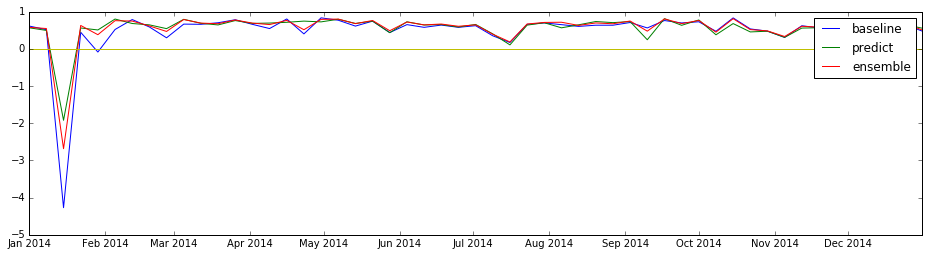

In [115]:
scores = score_df(trained)
plot_scores(scores)

In [116]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_1_2014.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2014-1-1':'2015-1-1'])

Predict:  0.628178570346
Ensemble:  0.634929628165
Baseline:  0.595947033601


## Pacific Highway South

### 2015

In [26]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

pr = run_multiweek(grid, 3, 5, datetime.date(2015, 1, 1), datetime.date(2016, 1, 1), 7)

In [37]:
first = datetime.date(2015, 1, 1)
last = datetime.date(2016, 1, 1)
test_days = 7
exclude = [datetime.date(2015, 10, 15), datetime.date(2015, 2, 19)]

trained = get_trained(first, last, test_days, exclude)

2015-01-01 {'model': 0.46990307719014135, 'ensemble': 0.50284696366738424, 'baseline': 0.53360635276911372}
2015-01-08 {'model': 0.38909399024410873, 'ensemble': 0.43317233422625923, 'baseline': 0.42777892104205117}
2015-01-15 {'model': -2.0167523567331953, 'ensemble': -2.1575372502433772, 'baseline': -2.5594198289083412}
2015-01-22 {'model': 0.25022423977961805, 'ensemble': -0.024464794150649505, 'baseline': -0.71456686843956074}
2015-01-29 {'model': -0.24304107629025085, 'ensemble': -0.62468547750129755, 'baseline': -1.8131967463785328}
2015-02-05 {'model': 0.53581912193230563, 'ensemble': 0.35643380354943732, 'baseline': -1.2446526859107325}
2015-02-12 {'model': 0.58348068019601507, 'ensemble': 0.67736120724406579, 'baseline': 0.56255811702560932}
2015-02-26 {'model': 0.54658268613935368, 'ensemble': 0.63090487795934824, 'baseline': 0.37507249104058504}
2015-03-05 {'model': 0.53094204792758137, 'ensemble': 0.40041087755609972, 'baseline': -0.49281888391150352}
2015-03-12 {'model': 0

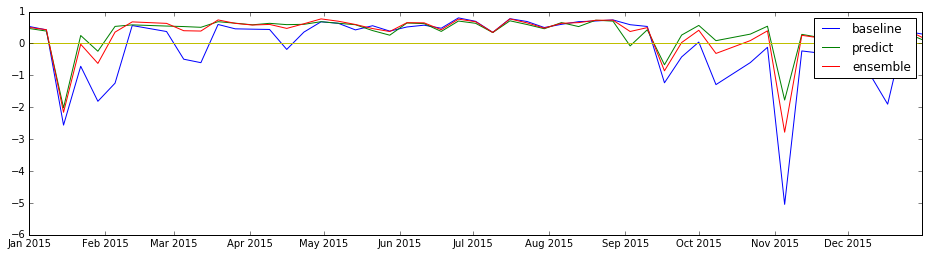

In [38]:
scores = score_df(trained)
plot_scores(scores)

In [39]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_5_2015.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2015-1-1':'2016-1-1'])

Predict:  0.510585079272
Ensemble:  0.522367396674
Baseline:  0.419433496676


### 2014

In [96]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2014, 1, 1)
last = datetime.date(2015, 1, 1)
pr5 = run_multiweek(grid, 3, 5, first, last, 7)

In [27]:
exclude = [datetime.date(2014,11,19)]
trained = get_trained(pr5, exclude)

NameError: name 'pr5' is not defined

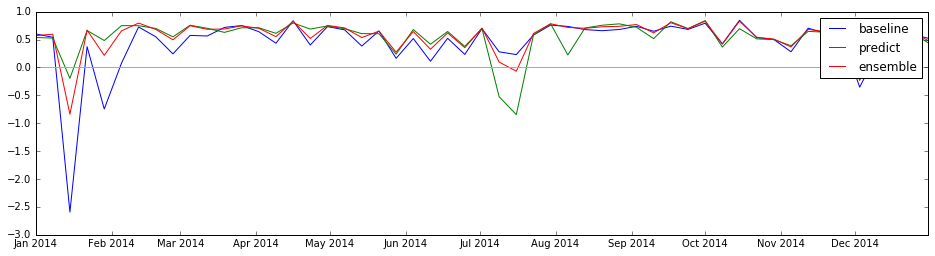

In [111]:
scores = score_df(trained)
plot_scores(scores)

In [112]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_5_2014.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2014-1-1':'2015-1-1'])

Predict:  0.609117332063
Ensemble:  0.635295178947
Baseline:  0.571960977333


### 2013

In [4]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2013, 1, 1)
last = datetime.date(2014, 1, 1)
pr5 = run_multiweek(grid, 3, 5, first, last, 7)

In [7]:
exclude = [datetime.date(2013,4,30)]
trained = get_trained(pr5, exclude)

2013-01-01 {'model': 0.60451338925167297, 'ensemble': 0.55965789412807199, 'baseline': 0.52714386334753927}
2013-01-08 {'model': 0.59520187218901, 'ensemble': 0.55103062616975862, 'baseline': 0.47259260150913907}
2013-01-15 {'model': -0.41526561007973695, 'ensemble': -0.930582140040211, 'baseline': -1.8850609304386472}
2013-01-22 {'model': 0.63727549750556267, 'ensemble': 0.63617183956642731, 'baseline': 0.32466918146331902}
2013-01-29 {'model': 0.68224675713423566, 'ensemble': 0.68209139988656986, 'baseline': 0.59581230778019889}
2013-02-05 {'model': 0.56859359238170604, 'ensemble': 0.422752464480177, 'baseline': 0.079662045097047329}
2013-02-12 {'model': 0.48176205549028295, 'ensemble': 0.58770558778632975, 'baseline': 0.70188772811611022}
2013-02-19 {'model': 0.58808946788855421, 'ensemble': 0.68266377970363412, 'baseline': 0.68959849078045421}
2013-02-26 {'model': 0.7636498745198842, 'ensemble': 0.76041519260398327, 'baseline': 0.71075124540121437}
2013-03-05 {'model': 0.6382939848

In [8]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_5_2013.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2013-1-1':'2014-1-1'])

Predict:  0.655880613339
Ensemble:  0.631858832073
Baseline:  0.58773246016


## 2012

In [9]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2012, 1, 1)
last = datetime.date(2013, 1, 1)
pr5 = run_multiweek(grid, 3, 5, first, last, 7)

In [16]:
exclude = [datetime.date(2012,4,29), datetime.date(2012,5,13), datetime.date(2012,12,2)]
trained = get_trained(pr5, exclude)

2012-01-01 {'model': 0.42830147024958976, 'ensemble': 0.38757121844658649, 'baseline': 0.34488557942283404}
2012-01-08 {'model': 0.44648987380446215, 'ensemble': 0.46004820883097797, 'baseline': 0.38230579834218859}
2012-01-15 {'model': 0.41650471246331522, 'ensemble': 0.32461416805825083, 'baseline': -0.082691595589748479}
2012-01-22 {'model': -0.88456890214754647, 'ensemble': -0.63958269681549162, 'baseline': -1.711013191878604}
2012-01-29 {'model': 0.65202077816226534, 'ensemble': 0.69237430599217742, 'baseline': 0.63535308330723983}
2012-02-05 {'model': 0.64015966090787124, 'ensemble': 0.60341973031419605, 'baseline': 0.5158700584755137}
2012-02-12 {'model': 0.47181611293979042, 'ensemble': 0.61770038745845146, 'baseline': 0.68062418521971102}
2012-02-19 {'model': 0.59033394449631649, 'ensemble': 0.70188741825875234, 'baseline': 0.73259316524039342}
2012-02-26 {'model': 0.52232404246227793, 'ensemble': 0.56814142805954471, 'baseline': 0.5992982632662649}
2012-03-04 {'model': 0.7357

In [17]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_5_2012.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results[str(first):str(last)])

Predict:  0.659955103703
Ensemble:  0.669042698179
Baseline:  0.635447127996


## 2011

In [18]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2011, 1, 1)
last = datetime.date(2012, 1, 1)
pr5 = run_multiweek(grid, 3, 5, first, last, 7)

In [24]:
exclude = [datetime.date(2011,8,20), datetime.date(2011,9,17)]
trained = get_trained(pr5, exclude)

2011-01-01 {'model': 0.28986517963135461, 'ensemble': 0.25619667066881646, 'baseline': 0.19097893951859679}
2011-01-08 {'model': 0.62175555592765164, 'ensemble': 0.51401521719970578, 'baseline': 0.30767568454739591}
2011-01-15 {'model': 0.37533478389478026, 'ensemble': 0.41979023424695716, 'baseline': 0.0054857658411261445}
2011-01-22 {'model': 0.56820483757325158, 'ensemble': 0.5319285178277765, 'baseline': 0.14955566699351153}
2011-01-29 {'model': 0.48503067131531907, 'ensemble': 0.61041930918589471, 'baseline': 0.50084378983714828}
2011-02-05 {'model': 0.22506449156543318, 'ensemble': 0.16600394955258824, 'baseline': -0.25505327712290149}
2011-02-12 {'model': 0.30425666663867568, 'ensemble': 0.38000327651727606, 'baseline': 0.39856451023840656}
2011-02-19 {'model': 0.52183029696981453, 'ensemble': 0.61704375104162656, 'baseline': 0.68007739348383844}
2011-02-26 {'model': 0.1447245203757479, 'ensemble': 0.231373850924529, 'baseline': 0.1580325048976936}
2011-03-05 {'model': 0.0774267

In [25]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_5_2011.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results[str(first):str(last)])

Predict:  0.566490587394
Ensemble:  0.579555710225
Baseline:  0.528526958613


## Peace Arch North
### 2015

In [5]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2015, 1, 1)
last = datetime.date(2016, 1, 1)
pr2 = run_multiweek(grid, 4, 2, first, last, 7)

In [16]:
exclude = [datetime.date(2015,5,28)]
trained = get_trained(pr2, exclude)

2015-01-01 {'model': 0.39954071691611326, 'ensemble': 0.30472179701165147, 'baseline': 0.24588725100921349}
2015-01-08 {'model': -0.13836174388787681, 'ensemble': 0.010964220331590613, 'baseline': -0.29447035481332717}
2015-01-15 {'model': -6.6342310544350775, 'ensemble': -9.022180617597197, 'baseline': -17.676242617906471}
2015-01-22 {'model': -0.35526436600993727, 'ensemble': -0.5975586698471822, 'baseline': -2.2937147386363241}
2015-01-29 {'model': -0.76534052000541908, 'ensemble': -1.9306199671274555, 'baseline': -6.1039907431967988}
2015-02-05 {'model': -0.17320405136280881, 'ensemble': -1.0045305876015358, 'baseline': -6.0129249650843448}
2015-02-12 {'model': 0.049528364798090196, 'ensemble': 0.12390990430465443, 'baseline': 0.185616186550698}
2015-02-19 {'model': -0.10337387388824015, 'ensemble': 0.51731538545256517, 'baseline': 0.47052649314694539}
2015-02-26 {'model': 0.2076256067922263, 'ensemble': -0.23767887178436919, 'baseline': -2.1050329409913529}
2015-03-05 {'model': 0.

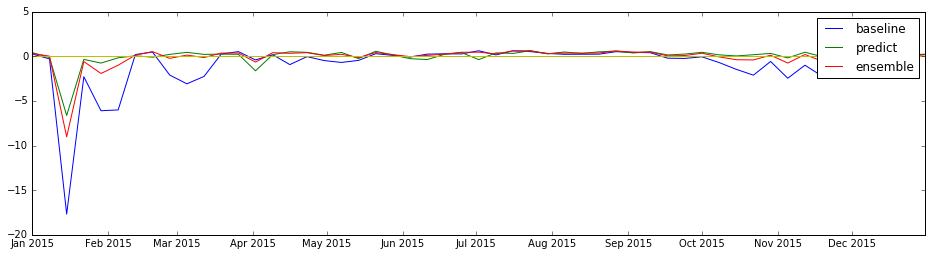

In [17]:
scores = score_df(trained)
plot_scores(scores)

In [18]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_2_2015.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2015-1-1':'2016-1-1'])

Predict:  0.301565565634
Ensemble:  0.336215457996
Baseline:  0.136155598384


### 2014

In [19]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2014, 1, 1)
last = datetime.date(2015, 1, 1)
pr2 = run_multiweek(grid, 4, 2, first, last, 7)

In [24]:
exclude = []#[datetime.date(2014,5,28)]
trained = get_trained(pr2, exclude)

2014-01-01 {'model': 0.15194386123645953, 'ensemble': 0.21005025287337298, 'baseline': 0.2846019203831649}
2014-01-08 {'model': 0.4477892982616396, 'ensemble': 0.29797868114267567, 'baseline': -0.066511700242518845}
2014-01-15 {'model': -0.20891998421251134, 'ensemble': -0.67759118138778884, 'baseline': -2.0536563004383668}
2014-01-22 {'model': 0.40066608512466462, 'ensemble': 0.33477808756179828, 'baseline': -0.10127337629082156}
2014-01-29 {'model': 0.48747755285151528, 'ensemble': 0.48672061314936743, 'baseline': -0.011384522610143}
2014-02-05 {'model': 0.57833988563415728, 'ensemble': 0.59954411931281038, 'baseline': 0.39473376341777255}
2014-02-12 {'model': 0.38018745004935539, 'ensemble': 0.40597193199722281, 'baseline': 0.40936072708075932}
2014-02-19 {'model': 0.21974500149736642, 'ensemble': 0.26025384358661097, 'baseline': 0.2923734895558503}
2014-02-26 {'model': -0.65075231898353225, 'ensemble': -0.2919594114577877, 'baseline': -0.19645122487558386}
2014-03-05 {'model': 0.09

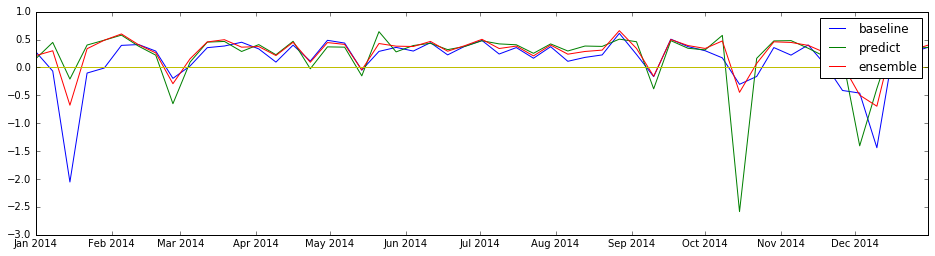

In [25]:
scores = score_df(trained)
plot_scores(scores)

In [26]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_2_2014.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2014-1-1':'2015-1-1'])

Predict:  0.417786299579
Ensemble:  0.417455227837
Baseline:  0.35456915731


## Pacific Highway North
### 2015

In [4]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2015, 1, 1)
last = datetime.date(2016, 1, 1)
pr6 = run_multiweek(grid, 4, 6, first, last, 7)

In [12]:
exclude = [datetime.date(2015,5,28)]
trained = get_trained(pr6, exclude)

2015-01-01 {'model': 0.37239990741748352, 'ensemble': 0.29723504024048819, 'baseline': 0.24731975974500331}
2015-01-08 {'model': -0.95761789558080834, 'ensemble': -0.19036074516578694, 'baseline': -0.50325865101347356}
2015-01-15 {'model': -1.5620407703232124, 'ensemble': -2.3253975302733862, 'baseline': -5.0620393827105836}
2015-01-22 {'model': -2.4376833049214004, 'ensemble': -1.8286480187936949, 'baseline': -3.836788130531299}
2015-01-29 {'model': -0.41775588073760228, 'ensemble': -0.915192319176656, 'baseline': -3.1880409767712141}
2015-02-05 {'model': -0.091707398864978806, 'ensemble': -0.81858090684365714, 'baseline': -6.123834058095297}
2015-02-12 {'model': 0.12096510419906048, 'ensemble': 0.19700491525916686, 'baseline': 0.16049673091068295}
2015-02-19 {'model': 0.29016349806828234, 'ensemble': 0.37125495040255641, 'baseline': 0.32699700229839124}
2015-02-26 {'model': -0.18944152555893279, 'ensemble': -0.90959216105060481, 'baseline': -4.1260635132519923}
2015-03-05 {'model': 0

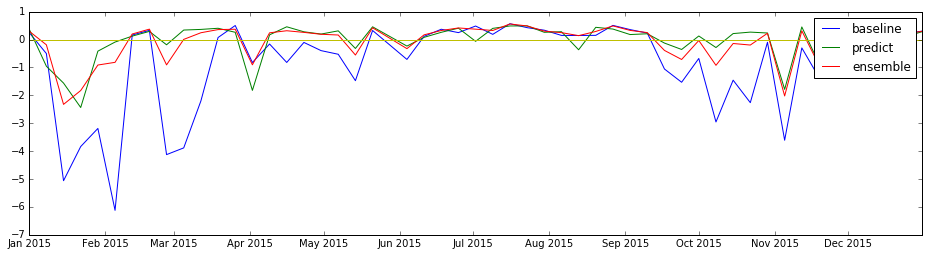

In [13]:
scores = score_df(trained)
plot_scores(scores)

In [14]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_6_2015.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2015-1-1':'2016-1-1'])

Predict:  0.243944924062
Ensemble:  0.272891607146
Baseline:  0.0294109858536


### 2014

In [20]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2014, 1, 1)
last = datetime.date(2015, 1, 1)
pr6 = run_multiweek(grid, 4, 6, first, last, 7)

In [28]:
exclude = []#[datetime.date(2014,5,28)]
trained = get_trained(pr6, exclude)

2014-01-01 {'model': 0.22781844207501201, 'ensemble': 0.22209419891478677, 'baseline': 0.24205713067569923}
2014-01-08 {'model': 0.21431744369701733, 'ensemble': 0.080282970045887359, 'baseline': -0.17987725304083924}
2014-01-15 {'model': -0.21213353168352422, 'ensemble': -0.21190540323726093, 'baseline': -0.67614686974584948}
2014-01-22 {'model': 0.17605057719027017, 'ensemble': 0.21520381541774702, 'baseline': 0.052369393131533437}
2014-01-29 {'model': 0.27426867399980226, 'ensemble': 0.31918018746130872, 'baseline': 0.033443284452879252}
2014-02-05 {'model': 0.3924314500302245, 'ensemble': 0.44519975837104986, 'baseline': 0.45271162843428603}
2014-02-12 {'model': 0.23990220224186976, 'ensemble': 0.32347853220826828, 'baseline': 0.38664166160386459}
2014-02-19 {'model': 0.39574184423820802, 'ensemble': 0.46039165827939887, 'baseline': 0.50501892372799229}
2014-02-26 {'model': -0.057818583868279205, 'ensemble': 0.068611517741318351, 'baseline': 0.073835768523976109}
2014-03-05 {'model

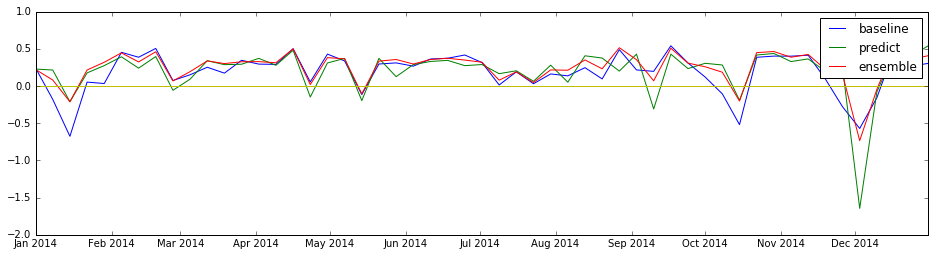

In [29]:
scores = score_df(trained)
plot_scores(scores)

In [30]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_6_2014.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2014-1-1':'2015-1-1'])

Predict:  0.350268268612
Ensemble:  0.362279036466
Baseline:  0.317647616861
